In [0]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
%matplotlib inline

In [267]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data

In [0]:
data_path = '/content/drive/My Drive/Diplom/data'

In [0]:
df_train = pd.read_csv(data_path + '/train.csv', index_col="id")
df_test = pd.read_csv(data_path + '/test.csv', index_col="id")
df_test_ans = pd.read_csv(data_path + "/ans.csv", index_col="id")
df_test_ans['sat_id'] = df_test['sat_id']
df_pred_sgp4 = pd.read_csv(data_path + "/pred_sgp.csv", index_col="id")

n_sat = len(pd.unique(df_train["sat_id"]))

In [0]:
from tqdm import tqdm

In [0]:
# features columns 
feature_cols = ["x_sim", "y_sim", "z_sim", "Vx_sim", "Vy_sim", "Vz_sim"]

# target variables columns 
target_cols = ["x", "y", "z", "Vx", "Vy", "Vz"]

In [0]:
def getX(df, feature_cols, target_cols):
  X_train = []
  y_train = []
  for i in range(n_sat):
    x = df[df['sat_id'] == i].sort_values(['epoch'])[feature_cols].to_numpy()
    y = df[df['sat_id'] == i].sort_values(['epoch'])[target_cols].to_numpy()
    X_train.append(x)
    y_train.append(y)
  return X_train, y_train

In [0]:
X_train, y_train = getX(df_train, feature_cols, target_cols)

In [0]:
y_train.shape

# RNN

In [0]:
import numpy as np 
from numpy import newaxis
import pandas as pd
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [0]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from IPython.display import clear_output

In [0]:
class LSTM_bases(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(6, 6)
        self.lin = nn.Linear(6, 6)
    
    def forward(self, X):
        h = (torch.randn(1, 1, 6), torch.randn(1, 1, 6))
        outputs = []
        for x in X:
          out, h = self.lstm(x.view(1, 1, -1).float(), h)
          out1 = self.lin(out)
          outputs.append(out1)
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [0]:
class RNN_bases(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.RNN(6, 6)
        self.lin = nn.Linear(6, 6)
    
    def forward(self, X):
        h = torch.randn(1, 1, 6)
        outputs = []
        for x in X:
          out, h = self.lstm(x.view(1, 1, -1).float(), h)
          out1 = self.lin(out)
          outputs.append(out1)
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [0]:
class GRU_bases(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.GRU(6, 6)
        self.lin = nn.Linear(6, 6)
    
    def forward(self, X):
        h = torch.randn(1, 1, 6)
        outputs = []
        for x in X:
          out, h = self.lstm(x.view(1, 1, -1).float(), h)
          out1 = self.lin(out)
          outputs.append(out1)
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [0]:
def train_epoch(model, optimizer):
    loss_log = []
    model.train()
    for i, data in enumerate(X_train):
        target = y_train[i]
        target = torch.tensor(target).float()
        data = torch.tensor(data)
        optimizer.zero_grad()
        output = model(data)
        loss_function = nn.MSELoss()        
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log   

def plot_history(train_history, title='loss'):
    clear_output()
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
def train(model, opt, n_epochs):
    train_log = []
    for epoch in range(n_epochs):
        print("Epoch {0} of {1}".format(epoch, n_epochs))
        train_loss = train_epoch(model, opt)
        train_log.extend(train_loss)
        plot_history(train_log)

In [0]:
def getX(df, feature_cols, target_cols):
  X_train = []
  y_train = []
  for i in range(n_sat):
    x = df[df['sat_id'] == i].sort_values(['epoch'])[feature_cols].to_numpy()
    y = df[df['sat_id'] == i].sort_values(['epoch'])[target_cols].to_numpy()
    x = np.expand_dims(x, 1)
    y = np.expand_dims(y, 1)
    X_train.append(x)
    y_train.append(y)
  return X_train, y_train

In [0]:
X_train, y_train = getX(df_train, feature_cols, target_cols)

In [292]:
X_train[0].shape

(215, 1, 6)

In [293]:
y_train[0].shape

(215, 1, 6)

In [0]:
import warnings
warnings.filterwarnings('ignore')

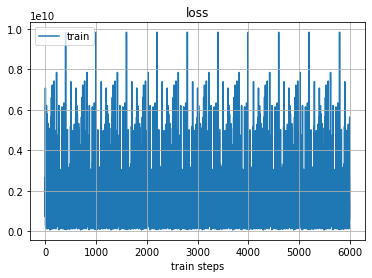

CPU times: user 26min 5s, sys: 2.34 s, total: 26min 7s
Wall time: 26min 11s


In [295]:
%%time
modelL = LSTM_bases()
opt = torch.optim.Adam(model.parameters(), lr=0.0005)
train(modelL, opt, 10)

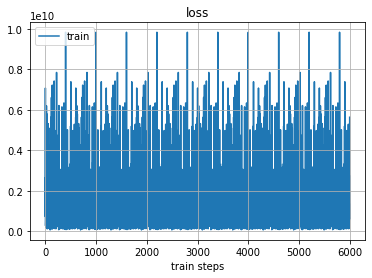

In [302]:
modelR = RNN_bases()
opt = torch.optim.Adam(model.parameters(), lr=0.0005)
train(modelR, opt, 10)

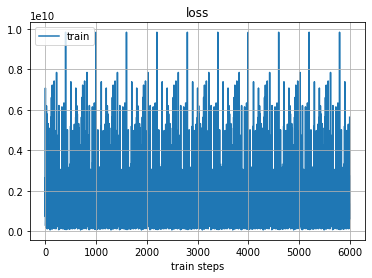

CPU times: user 26min 55s, sys: 2.36 s, total: 26min 58s
Wall time: 27min 1s


In [304]:
%%time
modelG = GRU_bases()
opt = torch.optim.Adam(model.parameters(), lr=0.0005)
train(modelG, opt, 10)

In [0]:
def test(model, name):
  pred = pd.DataFrame(columns=target_cols, index=df_test.index)
  X_test = df_test[feature_cols].values
  pred["sat_id"] = df_test["sat_id"]
  p = []
  for x in X_test:
    model.eval()
    p.append(model(torch.tensor(x).float().view(1, -1).view(1, 1, -1)).detach().numpy())
  p = np.array(p)
  p = p.reshape(302458, 6)
  for i, col in enumerate(target_cols):
    pred[col] = p[:, i]
  print_metrics(name, pred)

In [308]:
test(modelR, 'RNN')


RNN

IDAO score:  11.080449413655803
SMAPE IDAO:  0.889195505863442
SMAPE new:   1.7780232254877126


In [309]:
test(modelL, 'LSTM')


LSTM

IDAO score:  9.343313382257957
SMAPE IDAO:  0.9065668661774204
SMAPE new:   1.819967649391191


In [310]:
test(modelG, 'GRU')


GRU

IDAO score:  11.492832926745233
SMAPE IDAO:  0.8850716707325477
SMAPE new:   1.7595817874755963


# IDAO

In [0]:
pred_idao = pd.read_csv(data_path + '/sub_idao_example.csv', index_col='id')

In [244]:
pred_idao['sat_id'] = pred_lr['sat_id']

NameError: ignored

# Metrics

In [241]:
from metrics import smape_idao, idao_score, smape_new_vector_norm, mahalanobis_distance

ModuleNotFoundError: ignored

In [0]:
import numpy as np
from scipy.spatial.distance import mahalanobis
from numpy.linalg import norm
import pandas as pd

def smape_idao(pred, ans):
    pred = pred.values
    ans = ans.values
    return np.mean(np.abs(pred - ans) / (np.abs(pred) + np.abs(ans)))

def idao_score(pred, ans):
    return 100 * (1 - smape_idao(pred, ans))

def smape_new_vector_norm(pred, ans, av_score=True):
    assert set(ans.columns) == {'y', 'Vy', 'x', 'z', 'Vx', 'sat_id', 'Vz'}
    for c in ["x", "y", "z", "Vx", "Vy", "Vz"]:
        assert c in pred.columns
    assert (ans.index == pred.index).all()
    scores = []
    if not av_score:
        r_losses = v_losses = []
    for sat_id in pd.unique(ans["sat_id"]):
        idxs = (ans["sat_id"] == sat_id).values
        p = pred.loc[idxs, ["x", "y", "z", "Vx", "Vy", "Vz"]].values.astype("float")
        a = ans.loc[idxs, ["x", "y", "z", "Vx", "Vy", "Vz"]].values.astype("float")
        loss = p - a
        # coordinates
        r_loss = norm(loss[:, :3], axis=1) / (norm(p[:, :3], axis=1) + norm(a[:, :3], axis=1))
        r_loss = np.mean(r_loss)
        # velocities
        v_loss = norm(loss[:, 3:], axis=1) / (norm(p[:, 3:], axis=1) + norm(a[:, 3:], axis=1))     
        v_loss = np.mean(v_loss)
        # score
        scores.append(r_loss + v_loss)
        if not av_score:
            r_losses.append(r_loss)            
            v_losses.append(v_loss)
    if av_score:
        return np.mean(scores)
    else:
        return np.array(scores), np.array(r_losses), np.array(v_losses)

def mahalanobis_distance(pred, ans):
    # TODO: не ясно откуда берется ковариационная матрица
    scores = []
    for sat_id in pd.unique(ans["sat_id"]):
        idxs = (ans["sat_id"] == sat_id).values
        p = pred.loc[idxs, ["x", "y", "z", "Vx", "Vy", "Vz"]]
        a = ans.loc[idxs, ["x", "y", "z", "Vx", "Vy", "Vz"]]
        # coordinates
        r_loss = []
        for coord in ['x', 'y', 'z']:
            p_coord = p[coord].values.astype("float")
            a_coord = a[coord].values.astype("float")
            cov = np.cov(np.stack([p_coord, a_coord], axis=1))
            r_loss.append(mahalanobis(p_coord, a_coord, cov))
        # score
        scores.append(r_loss)
    return np.mean(scores)


In [0]:
def print_metrics(model_name, pred):
    print(f"\n{model_name}\n")
    print(f"IDAO score:  {idao_score(pred[target_cols], df_test_ans[target_cols])}")    
    print(f"SMAPE IDAO:  {smape_idao(pred[target_cols], df_test_ans[target_cols])}")    
    print(f"SMAPE new:   {smape_new_vector_norm(pred, df_test_ans)}")    
#     print(f"Mahalanobis: {mahalanobis_distance(pred, df_test_ans)}")

In [0]:
pred_sgp4 = df_pred_sgp4.rename(
    columns=dict(zip(feature_cols, target_cols)))

print_metrics("SGP4 – Total Score:", pred_sgp4)
print_metrics("LR – Total Score:", pred_lr)
print_metrics("IDAO – Total Score:", pred_idao)


SGP4 – Total Score:

IDAO score:  85.76745399276147
SMAPE IDAO:  0.14232546007238525
SMAPE new:   0.2105207081354428

LR – Total Score:

IDAO score:  91.81678353872567
SMAPE IDAO:  0.08183216461274322
SMAPE new:   0.1272771961005083

IDAO – Total Score:

IDAO score:  96.92031297743414
SMAPE IDAO:  0.030796870225658628
SMAPE new:   0.052050588061025874
